# Lesson 7 - Parkinson PCR

## Author - Robert Lisy

### Description:

Perform Principal Component Regression on a <a href="https://archive.ics.uci.edu/ml/datasets/parkinsons+telemonitoring">dataset that tracked patients with Parkinson's Disease</a>.

Citation: A Tsanas, MA Little, PE McSharry, LO Ramig (2009)
'Accurate telemonitoring of Parkinson's disease progression by non-invasive speech tests',
IEEE Transactions on Biomedical Engineering.

About the data:
This dataset is composed of a range of biomedical voice measurements from 42 people with early-stage Parkinson's disease recruited to a six-month trial of a telemonitoring device for remote symptom progression monitoring. The recordings were automatically captured in the patient's homes.

#### Instructions:

 1. Load the dataset.
 2. Create the X-matrix (one-hot encoding categorical factors).
 3. Scale the X-matrix.
 4. Create the principal components and do a simple plot of the explained variance.
 5. PCR - Linear regression with the principal components.

Report on:

 1. Number of components before and after (choose a smaller number of principal components and explain how you chose them).
 2. Interpret the adjusted R-squared.

In [15]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.metrics as metrics
scaler = StandardScaler()

filename = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/parkinsons_updrs.data"

In [2]:
parkinsons_df = pd.read_csv(filename)
parkinsons_df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [3]:
parkinsons_df.columns

Index(['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS',
       'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'],
      dtype='object')

In [4]:
# Define the target and features:
target_label = 'total_UPDRS'
non_features = ['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS']
feature_labels = [x for x in parkinsons_df.columns if x not in [target_label] + non_features]

# Filter out non-features and non-targets
parkinsons_df = parkinsons_df.drop(non_features, axis=1)

# One-hot encode inputs
parkinsons_expanded = pd.get_dummies(parkinsons_df, drop_first=True)
print(f'DataFrame one-hot-expanded shape: {parkinsons_expanded.shape}')

DataFrame one-hot-expanded shape: (5875, 17)


In [5]:
# Get target and original x-matrix
y = parkinsons_df[target_label]
X = parkinsons_df.values[:, 1:]

In [6]:
def pcr(X, y, pc: int):
    """
    Principal Component Regression in Python
    
    :param X: matrix of attributes for PCR
    :param y: target variable
    :pc: number principle components (expressed as an integer)

    Lots of credit from here (https://nirpyresearch.com/principal-component-regression-python/)
    
    """
    #Step 1: PCA on input data”’

    # Define the PCA object
    pca = PCA()
    # Preprocess (2) Standardize features by removing the mean and scaling to unit variance
    Xstd = StandardScaler().fit_transform(X[:,:])

    # Run PCA producing the reduced variable Xreg and select the first pc components
    Xreg = pca.fit_transform(Xstd)[:, :pc]

    # Step 2: regression on selected principal components”’
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Fit
    reg = regr.fit(Xreg, y)

    # Calibration
    y_c = regr.predict(Xreg)

    # Calculate scores for calibration
    score_c = r2_score(y, y_c)

    # Calculate mean square error for calibration
    mse_c = mean_squared_error(y, y_c)

    return(score_c, mse_c, reg)

In [7]:
# Loop over the potential values for the number of principal components, store the results of the PCR.
# We'll store the results into lists for inspection later.

score_c = []
mse = []
reg_models = []

for i in range(1, 10):
    s, m, r= pcr(X = X, y = y, pc = i)
    score_c.append(s)
    mse.append(m)
    reg_models.append(r)
    
mse = pd.DataFrame(np.array(mse), columns = ['Mean Squared Error'])
score_c = pd.DataFrame(np.array(score_c), columns = ['R2 Score'])

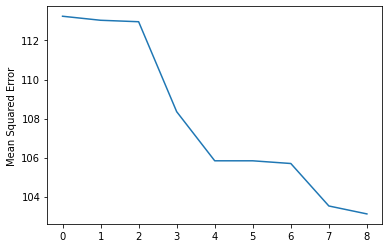

In [8]:
sns.lineplot(x = mse.index, y = mse['Mean Squared Error']);

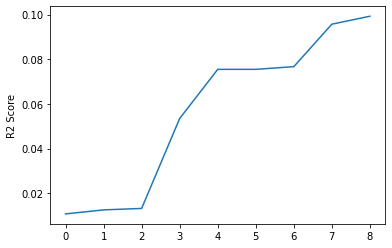

In [9]:
sns.lineplot(x = score_c.index, y = score_c['R2 Score']);

# Number of Components

Looking at the above, we see a huge improvement in the MSE and R2 score at 5 components for the PCA. We'll go forward with that number of components.


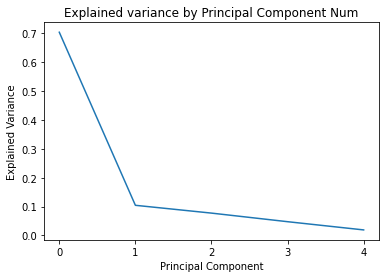

In [24]:
# Remake the PCA for plotting the variance with 5 components.

pca = PCA(n_components = 5)
# Preprocess (2) Standardize features by removing the mean and scaling to unit variance
Xstd = StandardScaler().fit_transform(X[:,:])
Xreg = pca.fit(Xstd)

var_df = pd.DataFrame(np.array(Xreg.explained_variance_ratio_), columns = ['Principal Component #'])

# Plot the 5 components
plt.xticks(range(0,5))
plt.title('Explained variance by Principal Component Num')
plt.xlabel('Principal Component')
sns.lineplot(x = var_df.index, y = var_df['Principal Component #']);
plt.ylabel('Explained Variance');

In [16]:
# From Stack Exchange... should let us reuse the sklearn model we have in our model list.
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [25]:
# Re-run fit_transform (instead of just fit) to actually do the PCA.
Xreg = pca.fit_transform(Xstd)[:, :5]

In [28]:
y_hat = reg_models[4].predict(Xreg)
regression_results(y, y_hat)

explained_variance:  0.0755
mean_squared_log_error:  0.1483
r2:  0.0755
MAE:  8.4069
MSE:  105.833
RMSE:  10.2875


# Summary of your results!

Number of components before and after:
- Initially there were 16 columns of data (after one hot encoding and removing the 'non_features'). I've reduced this down to 5 features using PCA. This number was chosen due to the large drop off in the explained variance when adding an additional 6th principle component.

Interpret the adjusted R-squared.
- This model explains (on average) 7% of the variance in the dependant variable (r2 of .0755).